In [2]:
# %pip install -q causal-learn

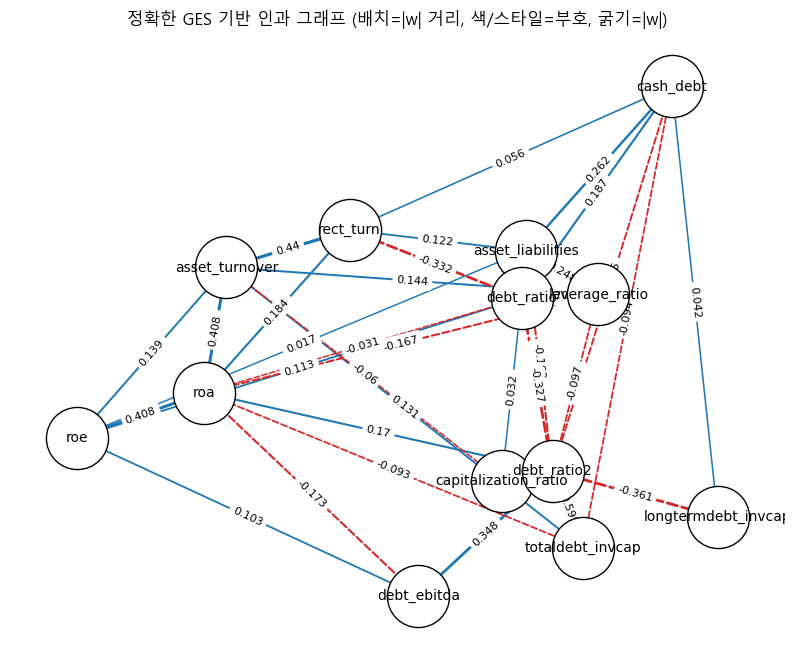

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# causal-learn: 정확한 GES 구현
from causallearn.search.ScoreBased.GES import ges   # 기본 점수는 BIC
# from causallearn.score.LocalScoreFunction import local_score_BIC

# 한글 폰트/마이너스 설정(선택)
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 0) 데이터 로드 (기존과 동일)
df = pd.read_csv("training_data.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols_for_w = list(feature_cols)
cols = cols_for_w  # 시각화 라벨 호환

# 1) 정확한 GES 실행 (기본 BIC 점수 사용)
X_np = X_base.values.astype(float)
Record = ges(X_np)  # 또는 Record = ges(X_np, score_func='local_score_BIC')
Gmat = Record['G'].graph  # orientation 행렬 (numpy.ndarray)
# 문서: G.graph[j,i]=1 & G.graph[i,j]=-1 이면 i -> j (i가 부모, j가 자식)

# 2) 방향성 인접행렬 A (i <- j 형태로 저장하기 위해 A[child, parent]=1)
p = len(cols_for_w)
A = np.zeros((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        # i -> j ?
        if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):
            A[j, i] = 1.0  # child=j, parent=i

# 3) 표준화 OLS로 엣지 가중치 행렬 W (i <- j)
Z = StandardScaler().fit_transform(X_np)
W = np.zeros_like(A, dtype=float)
for child in range(p):
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)  # 절편 없음(표준화)
    W[child, parents] = coef.astype(float)

# ============ 여기부터 시각화 개선(음수 가중치 지원) ============

# 시각화 임계 설정
USE_QUANTILE = False      # 분위수 임계 사용 여부
W_THRESHOLD = 0.01        # 고정 임계(|W|>0.01)
W_ABS_QUANTILE = 0.90     # 상위 10%만 (USE_QUANTILE=True일 때 사용)

TOP_K_EDGES = None        # 상위 |w| 간선만 표시하고 싶으면 정수(예: 100)로 설정

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W)

# 4) 임계 적용 + (선택) 상위 K개 필터 → DiGraph 구성
edges_all = []
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        w = float(W[i, j])
        if abs(w) > thr:
            edges_all.append((cols[j], cols[i], w))  # parent -> child, weight=w

# 상위 K개만 표시(선택)
if TOP_K_EDGES is not None and TOP_K_EDGES > 0 and len(edges_all) > TOP_K_EDGES:
    edges_all = sorted(edges_all, key=lambda t: abs(t[2]), reverse=True)[:TOP_K_EDGES]

G = nx.DiGraph()
for u, v, w in edges_all:
    G.add_edge(u, v, weight=round(w, 3))

# ---- 배치: 음수 가중치 문제 해결 (거리=1/(|w|+ε)로 양의 거리 그래프 H 구성)
eps = 1e-6
H = nx.Graph()  # 레이아웃 전용 보조 그래프(무향 + 양의 거리)
for u, v, d in G.edges(data=True):
    w = d.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)   # |w| 클수록 더 가까워지도록
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')  # 안정적 배치

# ---- 스타일: 부호/크기 시각화
max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] >= 0]
neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)

# 양수: 파란 실선 / 음수: 빨간 점선
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)

# 원래 가중치 라벨(부호 유지)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title("정확한 GES 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()


In [4]:
# ==============================================
# 회귀식 도출 (Scenario: rect_turn)
# - 대상: rect_turn의 "직접 자식"
# - 산출물:
#   1) scm_outputs/coeffs_rect_turn.csv
#   2) scm_outputs/residuals/{child}.npy
#   3) scm_outputs/equations_rect_turn.txt
# ==============================================
from pathlib import Path
import numpy as np
import pandas as pd

OUT_DIR = Path("scm_outputs")
RESID_DIR = OUT_DIR / "residuals"
OUT_DIR.mkdir(parents=True, exist_ok=True)
RESID_DIR.mkdir(parents=True, exist_ok=True)

scenario_var = "rect_turn"
if scenario_var not in cols:
    raise ValueError(f"'{scenario_var}'가 cols에 없습니다. 사용 가능한 컬럼 예시: {cols[:10]}")

scenario_idx = cols.index(scenario_var)

# 직접 자식: A[child, parent] == 1  ⇒ parent -> child
children_idx = np.where(A[:, scenario_idx] == 1.0)[0]
children = [cols[i] for i in children_idx]
print(f"[정보] '{scenario_var}'의 직접 자식 수: {len(children)} -> {children}")

records = []
equations_lines = []
n, p = Z.shape

for child in children_idx:
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue

    y_child = Z[:, child]
    X_par = Z[:, parents]

    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)  # 절편 없음(표준화)
    y_hat = X_par @ coef
    resid = y_child - y_hat

    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum(y_child**2)) + 1e-12
    r2 = 1.0 - ss_res / ss_tot

    child_name = cols[child]
    np.save(RESID_DIR / f"{child_name}.npy", resid)

    for p_idx, c in zip(parents, coef):
        records.append({
            "child": child_name,
            "parent": cols[p_idx],
            "coef": float(c),
            "r2": float(r2),
            "n_parents": int(parents.size)
        })

    parts = [f"{float(c):+.4f}·{cols[p_idx]}" for p_idx, c in zip(parents, coef)]
    eq = f"{child_name} = " + " ".join(parts) + f" + ε_{child_name}"
    equations_lines.append(eq)

if records:
    df_coef = pd.DataFrame(records).sort_values(["child", "parent"]).reset_index(drop=True)
    out_csv = OUT_DIR / f"coeffs_{scenario_var}.csv"
    df_coef.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"[저장] 계수 요약: {out_csv} (rows={len(df_coef)})")

    out_txt = OUT_DIR / f"equations_{scenario_var}.txt"
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("# 회귀식(표준화, 절편 없음)\n")
        f.write(f"# scenario_var = {scenario_var}\n\n")
        for line in equations_lines:
            f.write(line + "\n")
    print(f"[저장] 회귀식 요약: {out_txt}")
else:
    print("[알림] 저장할 레코드가 없습니다. (직접 자식/부모 조합 없음)")

print("\n[미리보기]")
for line in equations_lines[:5]:
    print(" -", line)


[정보] 'rect_turn'의 직접 자식 수: 5 -> ['asset_liabilities', 'asset_turnover', 'debt_ratio', 'roa', 'cash_debt']
[저장] 계수 요약: scm_outputs\coeffs_rect_turn.csv (rows=25)
[저장] 회귀식 요약: scm_outputs\equations_rect_turn.txt

[미리보기]
 - asset_liabilities = +0.2477·leverage_ratio +0.0166·roe -1.0511·debt_ratio +0.1217·rect_turn + ε_asset_liabilities
 - asset_turnover = +0.1442·leverage_ratio +0.1394·roe -0.0599·capitalization_ratio +0.1313·totaldebt_invcap +0.4397·rect_turn + ε_asset_turnover
 - debt_ratio = +0.7070·leverage_ratio +0.1127·roe -0.0306·roa +0.0320·capitalization_ratio -0.3325·rect_turn + ε_debt_ratio
 - roa = -0.1670·leverage_ratio +0.4084·roe +0.4085·asset_turnover -0.0926·totaldebt_invcap +0.1845·rect_turn + ε_roa
 - cash_debt = +0.2618·asset_liabilities +0.1871·debt_ratio -0.1263·debt_ratio2 +0.0424·longtermdebt_invcap -0.0944·totaldebt_invcap +0.0560·rect_turn + ε_cash_debt


In [5]:
# ==============================================
# do-Intervention 전파 (Scenario: rect_turn)
# - 입력: A (child,parent=1), W(OLS), Z(표준화), cols, X_base
# - 전파: 위상정렬로 부모→자식 갱신 (부트스트랩 잔차 사용)
# - 출력: 반복별 (Z_new, X_new_df) 리스트
# ==============================================
import numpy as np
import pandas as pd
import networkx as nx
from pathlib import Path

def simulate_do_rect_turn(
    A: np.ndarray,
    W: np.ndarray,
    Z: np.ndarray,
    cols: list,
    X_base: pd.DataFrame,
    delta_raw: float = 1.0,
    n_iter: int = 100,
    residual_dir: Path = Path("scm_outputs") / "residuals",
    use_bootstrap: bool = True,
    random_state: int = 42,
    save_each_iter: bool = False,
    save_dir: Path = Path("scm_outputs") / "synthetic"
):
    rng = np.random.default_rng(random_state)

    if "rect_turn" not in cols:
        raise ValueError("'rect_turn'가 cols에 없습니다.")
    idx_scn = cols.index("rect_turn")

    n, p = Z.shape
    mean_vec = X_base.values.astype(float).mean(axis=0)
    std_vec  = X_base.values.astype(float).std(axis=0, ddof=0)
    if np.any(std_vec == 0):
        raise ValueError("표준편차 0인 변수가 있습니다.")

    # DAG → 위상정렬
    G = nx.DiGraph()
    for child in range(p):
        parents = np.where(A[child, :] == 1.0)[0]
        for par in parents:
            G.add_edge(par, child)
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("그래프에 사이클이 있습니다.")

    descendants = nx.descendants(G, idx_scn)
    sub_nodes = [idx_scn] + sorted(descendants)
    topo_order = [u for u in nx.topological_sort(G) if u in sub_nodes]

    # 잔차 로딩(없으면 정규근사)
    residuals = {}
    for child in sub_nodes:
        child_name = cols[child]
        npy_path = residual_dir / f"{child_name}.npy"
        if npy_path.exists():
            residuals[child] = np.load(npy_path)
        else:
            residuals[child] = rng.normal(loc=0.0, scale=0.5, size=n)

    if save_each_iter:
        save_dir.mkdir(parents=True, exist_ok=True)

    results = []
    z_shift = delta_raw / std_vec[idx_scn]

    for it in range(n_iter):
        Z_new = Z.copy()
        # 개입
        Z_new[:, idx_scn] = Z_new[:, idx_scn] + z_shift

        # 전파
        for node in topo_order:
            if node == idx_scn:
                continue
            parents = np.where(A[node, :] == 1.0)[0]
            if parents.size == 0:
                continue
            lin = Z_new[:, parents] @ W[node, parents]
            if use_bootstrap:
                eps = rng.choice(residuals[node], size=n, replace=True)
            else:
                std_eps = np.std(residuals[node]) if residuals[node].size > 1 else 0.5
                eps = rng.normal(0.0, std_eps, size=n)
            Z_new[:, node] = lin + eps

        # 복원
        X_new = (Z_new * std_vec.reshape(1, -1)) + mean_vec.reshape(1, -1)
        X_new_df = pd.DataFrame(X_new, columns=cols)

        if save_each_iter:
            save_dir.mkdir(parents=True, exist_ok=True)
            X_new_df.to_csv(save_dir / f"synthetic_rect_turn_it{it+1:04d}.csv",
                            index=False, encoding="utf-8-sig")

        results.append((Z_new, X_new_df))

    return {
        "descendants_only": [cols[i] for i in descendants],
        "topo_order_names": [cols[i] for i in topo_order],
        "results": results
    }


In [6]:
# =============================
# 개입 실행 및 CSV 저장 래퍼
# =============================
from pathlib import Path
import pandas as pd

def run_and_save_rect_turn_csv(
    A, W, Z, cols, X_base, df, y,
    delta_raw=1.0, n_iter=100,
    residual_dir=Path("scm_outputs")/"residuals",
    out_dir=Path("scm_outputs")/"synthetic",
    random_state=42,
    use_bootstrap=True
):
    out_dir.mkdir(parents=True, exist_ok=True)

    sim = simulate_do_rect_turn(
        A=A, W=W, Z=Z, cols=cols, X_base=X_base,
        delta_raw=delta_raw, n_iter=n_iter,
        residual_dir=residual_dir, use_bootstrap=use_bootstrap,
        random_state=random_state, save_each_iter=False
    )

    combined = []
    # row id
    if "Unnamed: 0" in df.columns:
        row_ids = df["Unnamed: 0"].values
        row_id_name = "row_id"
    else:
        row_ids = df.index.values
        row_id_name = "row_id"

    for it, (_, X_new_df) in enumerate(sim["results"], start=1):
        X_new_df.insert(0, row_id_name, row_ids)
        if "label" in df.columns:
            X_new_df["label"] = y.values  # 라벨 유지 가정

        X_new_df["_iter"] = it
        X_new_df["_intervention"] = "rect_turn"
        X_new_df["_delta_raw"] = float(delta_raw)

        # 반복별 저장
        per_path = out_dir / f"synthetic_rect_turn_it{it:04d}.csv"
        X_new_df.to_csv(per_path, index=False, encoding="utf-8-sig")
        combined.append(X_new_df)

    # 통합 저장
    df_all = pd.concat(combined, axis=0, ignore_index=True)
    all_path = out_dir / "synthetic_rect_turn_all.csv"
    df_all.to_csv(all_path, index=False, encoding="utf-8-sig")

    print(f"[저장] 반복별 CSV: {out_dir / 'synthetic_rect_turn_it0001.csv'} ... it{n_iter:04d}.csv")
    print(f"[저장] 통합 CSV: {all_path} (rows={len(df_all)})")
    return {"descendants": sim["descendants_only"], "topo_order": sim["topo_order_names"], "all_path": all_path}

# ===== 실행 =====
res = run_and_save_rect_turn_csv(
    A, W, Z, cols, X_base, df, y,
    delta_raw=1.0, n_iter=100,
    residual_dir=Path("scm_outputs")/"residuals",
    out_dir=Path("scm_outputs")/"synthetic",
    random_state=42, use_bootstrap=True
)
print("전파 대상 descendants (미리보기):", res["descendants"][:10])
print("위상정렬 (미리보기):", res["topo_order"][:10])
print("통합 CSV 경로:", res["all_path"])


[저장] 반복별 CSV: scm_outputs\synthetic\synthetic_rect_turn_it0001.csv ... it0100.csv
[저장] 통합 CSV: scm_outputs\synthetic\synthetic_rect_turn_all.csv (rows=1788100)
전파 대상 descendants (미리보기): ['asset_liabilities', 'asset_turnover', 'debt_ratio', 'debt_ratio2', 'roa', 'cash_debt', 'debt_ebitda']
위상정렬 (미리보기): ['rect_turn', 'asset_turnover', 'roa', 'debt_ratio', 'asset_liabilities', 'debt_ratio2', 'cash_debt', 'debt_ebitda']
통합 CSV 경로: scm_outputs\synthetic\synthetic_rect_turn_all.csv


In [7]:
# ============================================
# GES/OLS DAG 기반 파생피처(m / mw) 생성 (원본 데이터에서만 계산)
# - 구조: A(child, parent)=1 (GES 결과 고정)
# - 가중치: W(child, parent) (표준화 OLS 계수 고정)
# ============================================
import numpy as np
import pandas as pd
from typing import Optional, List, Tuple

# ---- 유틸
def _remove_constant_columns(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.shape[1] == 0:
        return df
    var = df.var(axis=0, ddof=0)
    keep = var[~np.isclose(var.values, 0.0)].index
    return df[keep]

def _pick_top_k_edges_ols(
    W: np.ndarray, A: np.ndarray, cols: List[str],
    top_k: Optional[int], eps: float
) -> List[Tuple[int, int, float]]:
    """
    NOTE:
      - 구조는 반드시 A(child,parent)=1인 간선만 허용
      - 가중치는 OLS W(child,parent)
      - eps는 |W| 임계
    반환: (child_idx, parent_idx, w_ij) 리스트
    """
    p = W.shape[0]
    flat: List[Tuple[int, int, float]] = []
    for i in range(p):          # child
        for j in range(p):      # parent
            if i == j:
                continue
            if A[i, j] != 1.0:  # 구조 고정
                continue
            w = float(W[i, j])
            if abs(w) > eps:
                flat.append((i, j, w))
    # |w| 큰 순으로 정렬
    flat.sort(key=lambda t: (abs(t[2]), t[2]), reverse=True)
    if len(flat) == 0:
        return []
    return flat if top_k is None else flat[:min(top_k, len(flat))]

def build_feature_df_from_ges_ols(
    X_base: pd.DataFrame,
    cols: List[str],
    W: np.ndarray,           # OLS 가중치 (child,parent)
    A: np.ndarray,           # 구조 (child,parent) ∈ {0,1}
    feature_type: str = "mul",
    top_k: Optional[int] = 25,
    eps: float = 1e-12,
) -> pd.DataFrame:
    """
    feature_type:
      - "mul"  : parent * child
      - "mulw" : (W_ij) * (parent * child)
    """
    edges = _pick_top_k_edges_ols(W, A, cols, top_k=top_k, eps=eps)
    if len(edges) == 0:
        return pd.DataFrame(index=X_base.index)

    feats = {}
    for child_idx, parent_idx, w_ij in edges:
        parent_name = cols[parent_idx]
        child_name  = cols[child_idx]
        if feature_type == "mul":
            feats[f"{parent_name}_mul_{child_name}"]  = X_base[parent_name] * X_base[child_name]
        elif feature_type == "mulw":
            feats[f"{parent_name}_mulw_{child_name}"] = float(w_ij) * (X_base[parent_name] * X_base[child_name])

    X_feat = pd.DataFrame(feats, index=X_base.index)
    return _remove_constant_columns(X_feat)

# ---- 하이퍼파라미터
TOP_K_EDGES = 25
W_EPS = 1e-12  # |W| 임계

# ---- 파생피처 계산 (A, W, X_base, cols 는 앞선 GES/OLS 단계에서 준비되었다고 가정)
Xf_m  = build_feature_df_from_ges_ols(X_base, cols, W, A, feature_type="mul",  top_k=TOP_K_EDGES, eps=W_EPS)
Xf_mw = build_feature_df_from_ges_ols(X_base, cols, W, A, feature_type="mulw", top_k=TOP_K_EDGES, eps=W_EPS)

# 디버그: 실제 사용 간선 수
edge_mask = (A == 1.0) & (np.abs(W) > W_EPS)
edge_count = int(np.sum(edge_mask))
print(f"[DEBUG] GES/OLS edges(|W|>{W_EPS} & A==1): {edge_count}, Xf_m: {Xf_m.shape[1]}, Xf_mw: {Xf_mw.shape[1]}")


[DEBUG] GES/OLS edges(|W|>1e-12 & A==1): 35, Xf_m: 25, Xf_mw: 24


In [8]:
# ============================================
# 원본 데이터 O/F/OF(LGBM) 10-fold 평가 & 저장
# ============================================
import warnings
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
from lightgbm import LGBMClassifier
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime

RANDOM_STATE = 42
N_SPLITS = 10
PRINT_PROGRESS = True

def expected_calibration_error(y_true: np.ndarray, y_prob: np.ndarray, n_bins: int = 10) -> float:
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    if len(np.unique(y_true)) < 2:
        return np.nan
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece, total = 0.0, len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins-1 else (y_prob >= left) & (y_prob <= right)
        if mask.sum() == 0:
            continue
        acc  = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / total) * abs(acc - conf)
    return float(ece)

def best_threshold_by_f1(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    ts = np.linspace(0.05, 0.95, 19)
    scores = [(t, f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)) for t in ts]
    return float(max(scores, key=lambda x: x[1])[0])

def make_model_lgbm():
    return LGBMClassifier(
        n_estimators=500, learning_rate=0.05, num_leaves=31,
        max_depth=-1, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.0, reg_lambda=0.0, random_state=RANDOM_STATE, objective="binary"
    )

def run_cv_lgbm(X: pd.DataFrame, y: pd.Series, n_splits=10, random_state=42, tag: str = "") -> dict[str, float]:
    if X is None or X.shape[1] == 0:
        return {m: np.nan for m in ["f1","AUPRC","AUROC","Brier","ECE"]}
    X_np, y_np = X.values, y.values.astype(int)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []
    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...")
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )
        clf = make_model_lgbm()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            clf.fit(X_tr_sub, y_tr_sub)
        y_val_proba = clf.predict_proba(X_val)[:, 1]
        t = best_threshold_by_f1(y_val, y_val_proba)
        y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= t).astype(int)
        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        aurocs.append(roc_auc_score(y_te, y_proba))
        auprcs.append(average_precision_score(y_te, y_proba))
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))
    return {"f1": np.mean(f1s), "AUPRC": np.mean(auprcs), "AUROC": np.mean(aurocs),
            "Brier": np.mean(briers), "ECE": np.mean(eces)}

def eval_bucket_lgbm(X_base_df, X_feat_df, y, tag_prefix=""):
    res_O  = run_cv_lgbm(X_base_df, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"O-{tag_prefix}")
    if X_feat_df is None or X_feat_df.shape[1] == 0:
        res_F  = {m: np.nan for m in res_O}
        res_OF = run_cv_lgbm(X_base_df, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"OF-{tag_prefix}")
    else:
        res_F  = run_cv_lgbm(X_feat_df, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"F-{tag_prefix}")
        res_OF = run_cv_lgbm(pd.concat([X_base_df, X_feat_df], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag=f"OF-{tag_prefix}")
    return res_F, res_OF, res_O

# 보고서 디렉터리(덮어쓰기 방지용 타임스탬프)
REPORT_DIR = Path("reports") / datetime.now().strftime("%Y%m%d_%H%M%S")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# 리포트 표 생성
col_top     = ["O", "F", "OF"]
col_metrics = ["f1","AUPRC","AUROC","Brier","ECE"]
multi_cols  = pd.MultiIndex.from_product([col_top, col_metrics])
index_rows  = ["original","m","mw"]

res_F_m,  res_OF_m,  res_O   = eval_bucket_lgbm(X_base, Xf_m,  y, "m-orig")
res_F_mw, res_OF_mw, _       = eval_bucket_lgbm(X_base, Xf_mw, y, "mw-orig")

report = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)
for met in col_metrics:
    report.loc["original", ("O", met)]  = res_O[met]
    report.loc["m", ("F", met)]         = res_F_m[met]
    report.loc["mw", ("F", met)]        = res_F_mw[met]
    report.loc["m", ("OF", met)]        = res_OF_m[met]
    report.loc["mw", ("OF", met)]       = res_OF_mw[met]
report = report.astype(float).round(4)

report.to_csv(REPORT_DIR / "original_report.csv", encoding="utf-8-sig")
print(f"[저장] 원본 성능 요약: {REPORT_DIR/'original_report.csv'}")


[O-m-orig] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022139 -> initscore=-3.788010
[LightGBM] [Info] Start training from score -3.788010
[O-m-orig] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromS

In [9]:
# ============================================
# 개입 통합 CSV → 반복별 리포트 × N + 평균·CI + Δ 저장
# (DAG = GES/OLS 고정, 피처 생성도 동일 DAG/계수 사용)
# ============================================
from pathlib import Path
import numpy as np
import pandas as pd
from typing import Tuple  # Py3.8/3.9 호환을 위해

INTERV_PATH = Path("scm_outputs") / "synthetic" / "synthetic_rect_turn_all.csv"
ITERS_DIR   = REPORT_DIR / "iters"
ITERS_DIR.mkdir(parents=True, exist_ok=True)

def mean_ci(series: pd.Series) -> Tuple[float, float, float]:
    arr = series.dropna().values
    if arr.size == 0:
        return (np.nan, np.nan, np.nan)
    m = float(np.mean(arr))
    s = float(np.std(arr, ddof=1)) if arr.size > 1 else np.nan
    n = arr.size
    ci = 1.96 * s / np.sqrt(n) if (n > 1 and not np.isnan(s)) else np.nan
    return (m, m - ci, m + ci)

if INTERV_PATH.exists():
    df_interv_all = pd.read_csv(INTERV_PATH)

    # 원본에서 쓰던 피처 컬럼이 개입 CSV에도 모두 있는지 확인
    missing_in_interv = [c for c in cols if c not in df_interv_all.columns]
    if missing_in_interv:
        raise ValueError(f"개입 CSV에 다음 컬럼이 없습니다: {missing_in_interv[:10]}")

    col_top     = ["O", "F", "OF"]
    col_metrics = ["f1","AUPRC","AUROC","Brier","ECE"]
    multi_cols  = pd.MultiIndex.from_product([col_top, col_metrics])

    per_iter_rows = []

    for it, g in df_interv_all.groupby("_iter"):
        Xb_it = g[cols].copy()
        y_it  = g["label"].astype(int) if ("label" in g.columns) else y

        # ⬇️ GES/OLS 구조/계수로 파생 피처 재계산 (루프 안쪽에 인덴트!)
        Xf_m_it  = build_feature_df_from_ges_ols(
            X_base=Xb_it, cols=cols, W=W, A=A, feature_type="mul",
            top_k=TOP_K_EDGES, eps=W_EPS
        )
        Xf_mw_it = build_feature_df_from_ges_ols(
            X_base=Xb_it, cols=cols, W=W, A=A, feature_type="mulw",
            top_k=TOP_K_EDGES, eps=W_EPS
        )

        # 반복별 평가
        rF_m,  rOF_m,  rO   = eval_bucket_lgbm(Xb_it, Xf_m_it,  y_it, tag_prefix=f"m-it{int(it)}")
        rF_mw, rOF_mw, _    = eval_bucket_lgbm(Xb_it, Xf_mw_it, y_it, tag_prefix=f"mw-it{int(it)}")

        # 반복별 개별 리포트 저장
        iter_report = pd.DataFrame(index=["iteration","m","mw"], columns=multi_cols, dtype=float)
        for met in col_metrics:
            iter_report.loc["iteration", ("O", met)] = rO[met]
            iter_report.loc["m", ("F", met)]         = rF_m[met]
            iter_report.loc["m", ("OF", met)]        = rOF_m[met]
            iter_report.loc["mw", ("F", met)]        = rF_mw[met]
            iter_report.loc["mw", ("OF", met)]       = rOF_mw[met]
        iter_report = iter_report.astype(float).round(6)
        iter_report.to_csv(ITERS_DIR / f"it{int(it):04d}_report.csv", encoding="utf-8-sig")

        # 집계용 원시 행
        row = {"_iter": int(it)}
        for met in col_metrics:
            row[f"O.{met}"]    = rO[met]
            row[f"F_m.{met}"]  = rF_m[met]
            row[f"OF_m.{met}"] = rOF_m[met]
            row[f"F_mw.{met}"] = rF_mw[met]
            row[f"OF_mw.{met}"]= rOF_mw[met]
        per_iter_rows.append(row)

    # 반복별 원시값 저장
    df_per_iter = pd.DataFrame(per_iter_rows).sort_values("_iter").reset_index(drop=True)
    df_per_iter.round(6).to_csv(REPORT_DIR/"intervention_per_iter.csv", index=False, encoding="utf-8-sig")
    print(f"[저장] 개입 반복별 성능 원시값: {REPORT_DIR/'intervention_per_iter.csv'} (iters={df_per_iter['_iter'].nunique()})")

    # 평균·95% CI
    rows = []
    for c in [c for c in df_per_iter.columns if c != "_iter"]:
        m, lo, hi = mean_ci(df_per_iter[c])
        rows.append({"metric": c, "mean": m, "ci_low": lo, "ci_high": hi})
    df_mean_ci = pd.DataFrame(rows)
    df_mean_ci.to_csv(REPORT_DIR/"intervention_mean_ci.csv", index=False, encoding="utf-8-sig")
    print(f"[저장] 개입 평균·95% CI: {REPORT_DIR/'intervention_mean_ci.csv'}")

    # 원본 대비 Δ (원본 report와 비교)
    flat_orig = {}
    for met in col_metrics:
        flat_orig[f"O.{met}"]     = float(report.loc["original", ("O",  met)])
        flat_orig[f"OF_m.{met}"]  = float(report.loc["m",        ("OF", met)])
        flat_orig[f"OF_mw.{met}"] = float(report.loc["mw",       ("OF", met)])
        # 주의: 원본에는 F 단독 결과가 없으므로 Δ는 NaN 처리
        flat_orig[f"F_m.{met}"]   = np.nan
        flat_orig[f"F_mw.{met}"]  = np.nan

    delta_rows = []
    for _, r in df_mean_ci.iterrows():
        key = r["metric"]
        base = flat_orig.get(key, np.nan)
        delta_rows.append({
            "metric": key,
            "intervention_mean": r["mean"],
            "original": base,
            "delta": (r["mean"] - base) if (pd.notna(r["mean"]) and pd.notna(base)) else np.nan
        })
    pd.DataFrame(delta_rows).to_csv(REPORT_DIR/"delta_vs_original.csv", index=False, encoding="utf-8-sig")
    print(f"[저장] 원본 대비 Δ: {REPORT_DIR/'delta_vs_original.csv'}")
else:
    print("[알림] 개입 통합 CSV가 없어 원본만 평가했습니다. 경로 확인:",
          Path('scm_outputs') / 'synthetic' / 'synthetic_rect_turn_all.csv')


[O-m-it1] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022139 -> initscore=-3.788010
[LightGBM] [Info] Start training from score -3.788010
[O-m-it1] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022215 -> initscore=-3.784507
[LightGBM] [Info] Star

In [10]:
# ============================================
# NEW 1: residuals 기반 alpha(α) 분포 계산
# ============================================
from typing import Dict

def compute_alpha_distribution_from_residuals(
    residual_dir: Path,
    k: float = 0.2,
) -> Dict[str, float]:
    """
    residual_dir 안의 *.npy 잔차를 모두 모아
    alpha = 1 + k * ( (eps - mean_eps) / std_eps ) 로 정의
    - k: 스케일 조절 하이퍼파라미터 (0.1~0.3 정도 권장)
    반환: {mean, std, q05, q25, q50, q75, q95} 요약값
    """
    all_eps = []
    for npy_path in residual_dir.glob("*.npy"):
        eps = np.load(npy_path)
        if eps.size > 0:
            all_eps.append(eps.astype(float))
    if not all_eps:
        raise ValueError(f"[compute_alpha_distribution_from_residuals] '{residual_dir}'에 잔차 npy가 없습니다.")

    eps_all = np.concatenate(all_eps, axis=0)
    mu = float(eps_all.mean())
    sigma = float(eps_all.std(ddof=0))
    if sigma == 0:
        raise ValueError("잔차 표준편차가 0입니다. alpha를 정의할 수 없습니다.")

    eps_std = (eps_all - mu) / sigma
    alpha_all = 1.0 + k * eps_std

    stats = {
        "alpha_mean": float(alpha_all.mean()),
        "alpha_std":  float(alpha_all.std(ddof=0)),
        "alpha_q05":  float(np.quantile(alpha_all, 0.05)),
        "alpha_q25":  float(np.quantile(alpha_all, 0.25)),
        "alpha_q50":  float(np.quantile(alpha_all, 0.50)),
        "alpha_q75":  float(np.quantile(alpha_all, 0.75)),
        "alpha_q95":  float(np.quantile(alpha_all, 0.95)),
    }

    # 요약값 저장 (선택)
    alpha_stat_path = OUT_DIR / "alpha_summary_rect_turn.csv"
    pd.DataFrame([stats]).to_csv(alpha_stat_path, index=False, encoding="utf-8-sig")
    print(f"[저장] alpha 분포 요약: {alpha_stat_path}")
    print("[정보] alpha 요약:", stats)
    return stats

# alpha 분포 계산 실행 예시 (필요 시 한 번만 호출)
try:
    alpha_stats = compute_alpha_distribution_from_residuals(RESID_DIR, k=0.2)
except Exception as e:
    print("[경고] alpha 분포 계산 중 오류:", e)
    alpha_stats = None


[저장] alpha 분포 요약: scm_outputs\alpha_summary_rect_turn.csv
[정보] alpha 요약: {'alpha_mean': 1.0000000000000002, 'alpha_std': 0.2, 'alpha_q05': 0.7730461637613463, 'alpha_q25': 0.9462487555737944, 'alpha_q50': 1.0109158212377836, 'alpha_q75': 1.0547403285043675, 'alpha_q95': 1.2130358968643808}


In [11]:
# ============================================
# NEW 2: W′ = aW(1+β) 생성 도우미
# ============================================
from typing import Optional, Sequence

def make_scaled_W_single_parent(
    W: np.ndarray,
    A: np.ndarray,
    cols: Sequence[str],
    parent_name: str,
    scale: float,
    child_name: Optional[str] = None,
) -> np.ndarray:
    """
    특정 parent(예: rect_turn)에 연결된 edge weight를 scale 배로 스케일링한 새 W'를 생성.
    - parent_name: 스케일링 대상 parent 변수 이름
    - child_name: 특정 child만 스케일링하고 싶을 때 지정 (None이면 parent의 모든 자식 edge 대상)
    - scale: a(1+beta) 에 해당하는 스케일 계수
    """
    W_new = W.copy()
    parent_idx = cols.index(parent_name)

    if child_name is None:
        # parent_name의 모든 직접 자식 edge 스케일
        children_idx = np.where(A[:, parent_idx] == 1.0)[0]
    else:
        child_idx = cols.index(child_name)
        if A[child_idx, parent_idx] != 1.0:
            raise ValueError(f"{parent_name} -> {child_name} edge가 A에 없습니다.")
        children_idx = np.array([child_idx], dtype=int)

    for c in children_idx:
        old_w = W_new[c, parent_idx]
        W_new[c, parent_idx] = scale * old_w
    return W_new

def summarize_W_change(
    W_old: np.ndarray,
    W_new: np.ndarray,
    mask: Optional[np.ndarray] = None,
) -> Dict[str, float]:
    """
    W_old vs W_new 분포 비교용 요약값 계산
    - mask: True인 위치만 비교 (예: rect_turn 관련 edge만)
    """
    if mask is None:
        mask = np.ones_like(W_old, dtype=bool)
    diff = (W_new - W_old)[mask]
    w_old_sel = W_old[mask]
    w_new_sel = W_new[mask]
    if w_old_sel.size == 0:
        return {"n": 0}

    stats = {
        "n": int(w_old_sel.size),
        "old_mean": float(w_old_sel.mean()),
        "old_std":  float(w_old_sel.std(ddof=0)),
        "new_mean": float(w_new_sel.mean()),
        "new_std":  float(w_new_sel.std(ddof=0)),
        "diff_mean": float(diff.mean()),
        "diff_std":  float(diff.std(ddof=0)),
        "corr": float(np.corrcoef(w_old_sel.ravel(), w_new_sel.ravel())[0, 1]),
    }
    return stats


In [12]:
# ============================================
# NEW 3: rect_turn weight scaling 실험 (LightGBM)
# ============================================
def run_rect_turn_weight_scaling_experiment(
    X_base: pd.DataFrame,
    y: pd.Series,
    cols: Sequence[str],
    W: np.ndarray,
    A: np.ndarray,
    scales: Sequence[float] = (0.8, 0.9, 1.0, 1.1, 1.2),
    top_k_edges: Optional[int] = TOP_K_EDGES,
    w_eps: float = W_EPS,
    parent_name: str = "rect_turn",
    use_mw_only: bool = True,
) -> pd.DataFrame:
    """
    rect_turn을 parent로 갖는 edge들의 weight를 scale 배로 조정하면서
    LightGBM(O/F/OF) 성능이 어떻게 변하는지 평가.
    - scales: a(1+beta)에 해당하는 스케일 grid
    - use_mw_only: True면 mw 피처 위주로 해석(OF_mw 중심)
    반환: scale별 metric 요약 DataFrame
    """
    # baseline (원본 W, mw 피처 기준)
    Xf_mw_base = build_feature_df_from_ges_ols(
        X_base=X_base, cols=list(cols), W=W, A=A,
        feature_type="mulw", top_k=top_k_edges, eps=w_eps
    )
    res_F_mw_base, res_OF_mw_base, res_O_base = eval_bucket_lgbm(
        X_base, Xf_mw_base, y, tag_prefix="rect_turn_scale_1.0_base"
    )

    rows = []
    for s in scales:
        print(f"\n[rect_turn weight scaling] scale={s:.3f}")
        # rect_turn parent edge만 스케일링
        W_s = make_scaled_W_single_parent(
            W=W, A=A, cols=list(cols),
            parent_name=parent_name,
            scale=s,
            child_name=None,  # rect_turn의 모든 자식 edge 대상
        )

        # 분포 비교(선택)
        mask_rt = (A == 1.0)
        parent_idx = cols.index(parent_name)
        mask_rt = (A[:, parent_idx] == 1.0).reshape(-1, 1) & (np.arange(A.shape[1]) == parent_idx)
        # 위 mask_rt 생성이 까다로우면 간단히 전체 비교로 대체 가능

        stats_w = summarize_W_change(W, W_s)  # 여기선 전체 비교 예시
        print("[정보] W vs W_s 통계:", stats_w)

        # 스케일링된 W_s로 mw 파생 피처 생성
        Xf_mw_s = build_feature_df_from_ges_ols(
            X_base=X_base, cols=list(cols), W=W_s, A=A,
            feature_type="mulw", top_k=top_k_edges, eps=w_eps
        )

        # 성능 평가
        res_F_mw_s, res_OF_mw_s, res_O_s = eval_bucket_lgbm(
            X_base, Xf_mw_s, y, tag_prefix=f"rect_turn_scale_{s:.3f}"
        )

        row = {
            "scale": float(s),
            "old_mean_w": stats_w.get("old_mean", np.nan),
            "new_mean_w": stats_w.get("new_mean", np.nan),
            "w_corr":     stats_w.get("corr", np.nan),

            "O.AUROC_base":   res_O_base["AUROC"],
            "OF_mw.AUROC_base": res_OF_mw_base["AUROC"],
            "O.AUROC":        res_O_s["AUROC"],
            "OF_mw.AUROC":    res_OF_mw_s["AUROC"],
            "O.AUPRC_base":   res_O_base["AUPRC"],
            "OF_mw.AUPRC_base": res_OF_mw_base["AUPRC"],
            "O.AUPRC":        res_O_s["AUPRC"],
            "OF_mw.AUPRC":    res_OF_mw_s["AUPRC"],
            "O.Brier":        res_O_s["Brier"],
            "OF_mw.Brier":    res_OF_mw_s["Brier"],
            "O.ECE":          res_O_s["ECE"],
            "OF_mw.ECE":      res_OF_mw_s["ECE"],
        }

        # Δ 성능(OF_mw 기준) 추가
        row["delta_OF_mw.AUROC"] = row["OF_mw.AUROC"] - row["OF_mw.AUROC_base"]
        row["delta_OF_mw.AUPRC"] = row["OF_mw.AUPRC"] - row["OF_mw.AUPRC_base"]

        rows.append(row)

    df_scales = pd.DataFrame(rows).sort_values("scale").reset_index(drop=True)
    out_path = REPORT_DIR / "rect_turn_weight_scaling_lightgbm.csv"
    df_scales.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"[저장] rect_turn weight scaling 결과: {out_path}")
    return df_scales

# ===== rect_turn weight scaling 실험 실행 예시 =====
RECT_TURN_SCALES = [0.8, 0.9, 1.0, 1.1, 1.2]
try:
    df_rect_turn_scaling = run_rect_turn_weight_scaling_experiment(
        X_base=X_base,
        y=y,
        cols=cols,
        W=W,
        A=A,
        scales=RECT_TURN_SCALES,
        top_k_edges=TOP_K_EDGES,
        w_eps=W_EPS,
        parent_name="rect_turn",
    )
except Exception as e:
    print("[경고] rect_turn weight scaling 실험 중 오류:", e)


[O-rect_turn_scale_1.0_base] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022139 -> initscore=-3.788010
[LightGBM] [Info] Start training from score -3.788010
[O-rect_turn_scale_1.0_base] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022215 -> init

In [13]:
# ============================================
# NEW 4: random edge weight 개입 실험 (LightGBM)
# ============================================
def list_used_edges_from_WA(
    W: np.ndarray,
    A: np.ndarray,
    cols: Sequence[str],
    eps: float = 1e-12,
) -> pd.DataFrame:
    """
    A(child,parent)=1 & |W|>eps 인 edge 목록을 DataFrame으로 반환.
    """
    p = W.shape[0]
    rows = []
    for child in range(p):
        for parent in range(p):
            if child == parent:
                continue
            if A[child, parent] != 1.0:
                continue
            w_ij = float(W[child, parent])
            if abs(w_ij) <= eps:
                continue
            rows.append({
                "child_idx": child,
                "parent_idx": parent,
                "child": cols[child],
                "parent": cols[parent],
                "w": w_ij,
            })
    return pd.DataFrame(rows)


def run_random_edge_weight_experiments(
    X_base: pd.DataFrame,
    y: pd.Series,
    cols: Sequence[str],
    W: np.ndarray,
    A: np.ndarray,
    alpha_stats: Optional[Dict[str, float]] = None,
    n_runs: int = 50,
    k_edges_per_run: int = 3,
    betas: Sequence[float] = (0.0, 0.2, 0.5),
    top_k_edges: Optional[int] = TOP_K_EDGES,
    w_eps: float = W_EPS,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    - 매 run마다 k_edges_per_run 개의 edge를 random으로 선택
    - 각 edge에 대해 alpha ~ N(alpha_mean, alpha_std), beta는 betas 중 random 선택
    - scale = alpha * (1+beta)로 W′ = scale * W
    - 그 W′로 mw 피처 생성 후 LightGBM 평가 → baseline과 Δmetric 계산
    - 반환:
        - df_runs: run별 metric/Δ
        - df_edge_effect: edge별 ΔAUROC 요약(mean, std, 개선비율 등)
    """
    rng = np.random.default_rng(42)

    # baseline (W, mw 피처 기준)
    Xf_mw_base = build_feature_df_from_ges_ols(
        X_base=X_base, cols=list(cols), W=W, A=A,
        feature_type="mulw", top_k=top_k_edges, eps=w_eps
    )
    res_F_mw_base, res_OF_mw_base, res_O_base = eval_bucket_lgbm(
        X_base, Xf_mw_base, y, tag_prefix="random_edge_base"
    )

    edges_df = list_used_edges_from_WA(W, A, cols, eps=w_eps)
    if edges_df.empty:
        raise ValueError("사용 가능한 edge가 없습니다 (|W| <= eps).")

    # alpha 분포 파라미터 설정
    if alpha_stats is not None:
        a_mu = alpha_stats.get("alpha_mean", 1.0)
        a_sd = alpha_stats.get("alpha_std", 0.1)
    else:
        a_mu = 1.0
        a_sd = 0.1
    if a_sd <= 0:
        a_sd = 0.1

    print(f"[정보] random edge 실험 alpha ~ N({a_mu:.3f}, {a_sd:.3f}^2), betas={betas}")

    runs_rows = []
    # edge별 Δ 리스트 저장용
    edge_delta_aurocs: Dict[Tuple[int, int], list] = {}

    for run in range(1, n_runs + 1):
        # 무작위 edge subset 선택
        chosen_idx = rng.choice(edges_df.index.values, size=min(k_edges_per_run, len(edges_df)), replace=False)
        chosen_edges = edges_df.loc[chosen_idx].reset_index(drop=True)

        W_run = W.copy()
        edge_info_for_run = []

        for _, row in chosen_edges.iterrows():
            child_idx = int(row["child_idx"])
            parent_idx = int(row["parent_idx"])
            w_ij = float(row["w"])

            alpha = float(rng.normal(a_mu, a_sd))
            beta = float(rng.choice(betas))
            scale = alpha * (1.0 + beta)

            old_w = W_run[child_idx, parent_idx]
            W_run[child_idx, parent_idx] = scale * old_w

            edge_key = (child_idx, parent_idx)
            edge_info_for_run.append({
                "child_idx": child_idx,
                "parent_idx": parent_idx,
                "child": row["child"],
                "parent": row["parent"],
                "old_w": old_w,
                "new_w": W_run[child_idx, parent_idx],
                "alpha": alpha,
                "beta": beta,
                "scale": scale,
            })

        # 스케일링된 W_run으로 mw 피처 생성
        Xf_mw_run = build_feature_df_from_ges_ols(
            X_base=X_base, cols=list(cols), W=W_run, A=A,
            feature_type="mulw", top_k=top_k_edges, eps=w_eps
        )

        # LightGBM 평가
        res_F_mw_run, res_OF_mw_run, res_O_run = eval_bucket_lgbm(
            X_base, Xf_mw_run, y, tag_prefix=f"random_edge_run{run:03d}"
        )

        # run 단위 결과(OF_mw 기준 Δ)
        run_row = {
            "run": run,
            "O.AUROC_base": res_O_base["AUROC"],
            "OF_mw.AUROC_base": res_OF_mw_base["AUROC"],
            "O.AUROC": res_O_run["AUROC"],
            "OF_mw.AUROC": res_OF_mw_run["AUROC"],
            "delta_OF_mw.AUROC": res_OF_mw_run["AUROC"] - res_OF_mw_base["AUROC"],
            "O.AUPRC_base": res_O_base["AUPRC"],
            "OF_mw.AUPRC_base": res_OF_mw_base["AUPRC"],
            "O.AUPRC": res_O_run["AUPRC"],
            "OF_mw.AUPRC": res_OF_mw_run["AUPRC"],
            "delta_OF_mw.AUPRC": res_OF_mw_run["AUPRC"] - res_OF_mw_base["AUPRC"],
        }
        runs_rows.append(run_row)

        # edge별 ΔAUROC 기록
        for info in edge_info_for_run:
            key = (info["child_idx"], info["parent_idx"])
            edge_delta_aurocs.setdefault(key, []).append(run_row["delta_OF_mw.AUROC"])

    df_runs = pd.DataFrame(runs_rows).sort_values("run").reset_index(drop=True)
    out_runs_path = REPORT_DIR / "random_edge_runs_lightgbm.csv"
    df_runs.to_csv(out_runs_path, index=False, encoding="utf-8-sig")
    print(f"[저장] random edge run별 결과: {out_runs_path}")

    # edge별 ΔAUROC 요약
    edge_rows = []
    for (child_idx, parent_idx), deltas in edge_delta_aurocs.items():
        deltas_arr = np.array(deltas, dtype=float)
        child_name = cols[child_idx]
        parent_name = cols[parent_idx]
        mean_delta = float(deltas_arr.mean())
        std_delta = float(deltas_arr.std(ddof=0)) if deltas_arr.size > 1 else 0.0
        pos_ratio = float((deltas_arr > 0).mean())

        edge_rows.append({
            "child_idx": child_idx,
            "parent_idx": parent_idx,
            "child": child_name,
            "parent": parent_name,
            "n_runs": int(deltas_arr.size),
            "mean_delta_OF_mw.AUROC": mean_delta,
            "std_delta_OF_mw.AUROC": std_delta,
            "pos_ratio_delta_OF_mw.AUROC": pos_ratio,
        })

    df_edge_effect = pd.DataFrame(edge_rows).sort_values(
        "mean_delta_OF_mw.AUROC", ascending=False
    ).reset_index(drop=True)
    out_edge_path = REPORT_DIR / "random_edge_effects_lightgbm.csv"
    df_edge_effect.to_csv(out_edge_path, index=False, encoding="utf-8-sig")
    print(f"[저장] random edge별 ΔAUROC 요약: {out_edge_path}")

    return df_runs, df_edge_effect

# ===== random edge 개입 실험 실행 예시 =====
try:
    df_random_runs, df_random_edge_effect = run_random_edge_weight_experiments(
        X_base=X_base,
        y=y,
        cols=cols,
        W=W,
        A=A,
        alpha_stats=alpha_stats,   # 위에서 계산한 alpha 분포 요약 사용 (없으면 None)
        n_runs=50,
        k_edges_per_run=3,
        betas=(0.0, 0.2, 0.5),
        top_k_edges=TOP_K_EDGES,
        w_eps=W_EPS,
    )
except Exception as e:
    print("[경고] random edge weight 실험 중 오류:", e)


[O-random_edge_base] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022139 -> initscore=-3.788010
[LightGBM] [Info] Start training from score -3.788010
[O-random_edge_base] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022215 -> initscore=-3.784507


In [14]:
from pathlib import Path
import numpy as np
import pandas as pd

RECT_TURN_EDGE_DIR = Path("scm_outputs") / "rect_turn_edges"
RECT_TURN_EDGE_DIR.mkdir(parents=True, exist_ok=True)

def fit_rect_turn_parent_edges_ols(
    A: np.ndarray,
    Z: np.ndarray,
    cols: list,
    scenario_var: str = "rect_turn",
    out_dir: Path = RECT_TURN_EDGE_DIR,
):
    """
    DAG(A)에서 rect_turn이 parent인 edge만 골라
    child_z ~ rect_turn_z 단일 OLS 수행.
    - 계수/통계: rect_turn_edge_coeffs.csv
    - residual: rect_turn_edge_residuals/{child}.npy
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    resid_dir = out_dir / "rect_turn_edge_residuals"
    resid_dir.mkdir(parents=True, exist_ok=True)

    if scenario_var not in cols:
        raise ValueError(f"{scenario_var} 가 cols에 없음")

    p_idx = cols.index(scenario_var)
    children_idx = np.where(A[:, p_idx] == 1.0)[0]
    children = [cols[i] for i in children_idx]

    records = []
    x = Z[:, p_idx].reshape(-1, 1)  # rect_turn (표준화)

    for c in children_idx:
        y = Z[:, c]
        coef, *_ = np.linalg.lstsq(x, y, rcond=None)
        y_hat = x @ coef
        resid = y - y_hat

        ss_res = float(np.sum(resid**2))
        ss_tot = float(np.sum((y - y.mean())**2)) + 1e-12
        r2 = 1.0 - ss_res / ss_tot

        child_name = cols[c]
        np.save(resid_dir / f"{child_name}.npy", resid)

        records.append({
            "child": child_name,
            "parent": scenario_var,
            "coef": float(coef[0]),
            "r2": float(r2),
            "n": int(len(y)),
        })

    df = pd.DataFrame(records)
    coef_path = out_dir / "rect_turn_edge_coeffs.csv"
    df.to_csv(coef_path, index=False, encoding="utf-8-sig")
    print(f"[저장] rect_turn 부모 edge 단일 OLS 계수: {coef_path}")
    print(f"[정보] rect_turn parent children: {children}")
    return {"coeffs_path": coef_path, "resid_dir": resid_dir, "children": children}

# 실행 예시 (A, Z, cols 이미 존재한다고 가정)
rect_turn_edge_info = fit_rect_turn_parent_edges_ols(A, Z, cols)


[저장] rect_turn 부모 edge 단일 OLS 계수: scm_outputs\rect_turn_edges\rect_turn_edge_coeffs.csv
[정보] rect_turn parent children: ['asset_liabilities', 'asset_turnover', 'debt_ratio', 'roa', 'cash_debt']


In [15]:
def build_alpha_sampler_from_rect_turn_residuals(
    resid_dir: Path,
    k: float = 0.2,
):
    """
    rect_turn_edge_residuals/*.npy 전체를 모아
    eps를 표준화한 뒤 alpha = 1 + k * eps_std 로 정의.
    반환: alpha를 샘플링하는 함수 sample_alpha(n, rng)
    """
    all_eps = []
    for npy in resid_dir.glob("*.npy"):
        eps = np.load(npy)
        if eps.size > 0:
            all_eps.append(eps.astype(float))
    if not all_eps:
        raise ValueError("rect_turn edge residual npy 없음")

    eps_all = np.concatenate(all_eps, axis=0)
    mu = float(eps_all.mean())
    sigma = float(eps_all.std(ddof=0))
    if sigma == 0:
        raise ValueError("rect_turn residual 분산 0")

    eps_std = (eps_all - mu) / sigma
    alpha_all = 1.0 + k * eps_std

    def sample_alpha(n: int, rng: np.random.Generator) -> np.ndarray:
        return rng.choice(alpha_all, size=n, replace=True)

    print(f"[정보] alpha 분포: mean={alpha_all.mean():.4f}, std={alpha_all.std(ddof=0):.4f}")
    return sample_alpha

# 실행 예시
alpha_sampler = build_alpha_sampler_from_rect_turn_residuals(
    rect_turn_edge_info["resid_dir"],
    k=0.2,
)


[정보] alpha 분포: mean=1.0000, std=0.2000


In [16]:
def make_W_with_alpha_for_rect_turn_edges(
    W_base: np.ndarray,
    A: np.ndarray,
    cols: list,
    alpha: float,
    beta: float = 0.0,
    scenario_var: str = "rect_turn",
) -> np.ndarray:
    """
    rect_turn이 parent인 edge에만 W' = alpha * W * (1+beta) 적용.
    나머지 edge는 W 그대로 유지.
    """
    W_new = W_base.copy()
    p_idx = cols.index(scenario_var)
    children_idx = np.where(A[:, p_idx] == 1.0)[0]

    scale = alpha * (1.0 + beta)
    for c in children_idx:
        W_new[c, p_idx] = scale * W_new[c, p_idx]

    return W_new

# 예시: 한 번 개입 시
rng = np.random.default_rng(42)
alpha_sample = float(alpha_sampler(1, rng)[0])
beta_val = 0.2  # 예시

W_alpha = make_W_with_alpha_for_rect_turn_edges(
    W_base=W,
    A=A,
    cols=cols,
    alpha=alpha_sample,
    beta=beta_val,
    scenario_var="rect_turn",
)

# 이제 기존 simulate_do_rect_turn 호출 시 W 대신 W_alpha 사용
sim = simulate_do_rect_turn(
    A=A,
    W=W_alpha,
    Z=Z,
    cols=cols,
    X_base=X_base,
    delta_raw=1.0,
    n_iter=10,  # 예시
    residual_dir=Path("scm_outputs")/"residuals",
    use_bootstrap=True,
    random_state=42,
    save_each_iter=False,
)
